# Forecasting Consensus Expectations: Initial Jobless Claims
## Point and Directional Forecasts

In [3]:
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

from tqdm.auto import tqdm
from scipy import stats, special
from scipy.optimize import brentq
from collections import defaultdict
from itertools import product
from scipy.stats import t as student_t, norm, binomtest, jarque_bera
from arch.univariate import ConstantMean, GARCH, StudentsT
from arch.univariate.base import ConvergenceWarning
from IPython.display import display, Markdown

In [4]:
OUT_DIR = "../out"         
DF_FILE       = "ijc_df.parquet"
DF_FULL_FILE  = "ijc_df_full.parquet"

df       = pd.read_parquet(os.path.join(OUT_DIR, DF_FILE),      engine="pyarrow")
df_full  = pd.read_parquet(os.path.join(OUT_DIR, DF_FULL_FILE), engine="pyarrow")

print("df shape     :", df.shape)
print("df_full shape:", df_full.shape)

df shape     : (180723, 10)
df_full shape: (213693, 10)


In [24]:
df_full.head()

,release_date,period,median_survey,actual,economist,firm,forecast,asof,error,surprise
0,2006-01-05,2005-12-31,320.000,291.000,Michelle Meyer,Mastercard International Inc,NaN,NaT,NaN,-29.000
1,2006-01-05,2005-12-31,320.000,291.000,Michael Derks,Fxpro Financial Services Ltd,NaN,NaT,NaN,-29.000
2,2006-01-05,2005-12-31,320.000,291.000,Michael E Feroli,JP Morgan Securities LLC,NaN,NaT,NaN,-29.000
3,2006-01-05,2005-12-31,320.000,291.000,Michael Gapen,Morgan Stanley & Co LLC,NaN,NaT,NaN,-29.000
4,2006-01-05,2005-12-31,320.000,291.000,Michael Moran,Daiwa Capital Mkts,NaN,NaT,NaN,-29.000


In [11]:
# 1 ▸ quick schema check ───────────────────────────────────────
for col in ["forecast", "actual", "error"]:
    assert col in df.columns and col in df_full.columns, f"Missing {col}"

# 2 ▸ grid parameters (re-declare here if needed) ──────────────
contiguity_windows = [3, 6, 12, 24]
methods            = ["inverse_mse", "inverse_mae", "equal_weight"]
ridge              = 1e-6

def run_static_panel(df_panel: pd.DataFrame, name: str):
    dates = np.sort(df_panel["release_date"].unique())
    eval_rows, live_rows = [], []

    for window, method in tqdm(product(contiguity_windows, methods),
                               total=len(contiguity_windows)*len(methods),
                               desc=f"{name} grid"):

        preds = []                     # per-release records
        for idx in range(window, len(dates)):
            t = dates[idx]
            # ----- look-back slice -----
            hist = df_panel[df_panel["release_date"].isin(dates[idx-window:idx])]
            # economists with all forecasts in window
            econs = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
            econs = econs[econs].index
            if econs.empty:  continue

            if method == "equal_weight":
                w = pd.Series(1.0, index=econs)
            else:
                grp = hist[hist["economist"].isin(econs)].groupby("economist")["error"]
                score = grp.apply(lambda s: np.nanmean(s**2) if method=="inverse_mse"
                                  else np.nanmean(np.abs(s)))
                w = 1.0/(score+ridge)
            w /= w.sum()

            # ----- current forecasts -----
            cur = df_panel[(df_panel["release_date"]==t) & (df_panel["economist"].isin(w.index))]
            f_t = cur.set_index("economist")["forecast"].dropna()
            w   = w.reindex(f_t.index).dropna()
            if w.empty:  continue
            w /= w.sum()

            smart  = np.dot(w, f_t.loc[w.index])
            median = df_panel.loc[df_panel["release_date"]==t, "forecast"].dropna().median()
            actual = df_panel.loc[df_panel["release_date"]==t, "actual"].iloc[0]
            preds.append((t, smart, median, actual))

        # nothing for this (window,method)?
        if not preds:  continue

        oos = pd.DataFrame(preds, columns=["date","smart","median","actual"])

        # save unreleased forecast (if latest actual is NaN)
        unreleased = oos[oos["actual"].isna()]
        if not unreleased.empty:
            last = unreleased.iloc[-1]
            live_rows.append({"panel" : name,
                              "window": window,
                              "method": method,
                              "date"  : last["date"],
                              "smart" : last["smart"],
                              "median": last["median"],
                              "pred_dir": int(last["smart"] > last["median"]) })

        # evaluation on realised months only
        eval_df = oos.dropna(subset=["actual"]).copy()
        if eval_df.empty:  continue

        eval_df["smart_err"]  = eval_df["smart"]  - eval_df["actual"]
        eval_df["median_err"] = eval_df["median"] - eval_df["actual"]
        eval_df["actual_dir"] = (eval_df["actual"] > eval_df["median"]).astype(int)
        eval_df["pred_dir"]   = (eval_df["smart"]  > eval_df["median"]).astype(int)

        obs         = len(eval_df)
        rmse_smart  = np.sqrt((eval_df["smart_err"]**2 ).mean())
        rmse_median = np.sqrt((eval_df["median_err"]**2).mean())

        d       = eval_df["smart_err"]**2 - eval_df["median_err"]**2
        dm_stat = d.mean()/d.std(ddof=1)*np.sqrt(obs)
        dm_p    = 2*(1-stats.norm.cdf(abs(dm_stat)))

        hits     = (eval_df["actual_dir"] == eval_df["pred_dir"]).astype(int)
        hit_rate = hits.mean()
        binom_p  = stats.binomtest(hits.sum(), obs, 0.5).pvalue
        p1,p2    = eval_df["pred_dir"].mean(), eval_df["actual_dir"].mean()
        c_joint  = (eval_df["pred_dir"] & eval_df["actual_dir"]).mean()
        pt_stat  = (c_joint-p1*p2)/np.sqrt(p1*p2*(1-p1)*(1-p2)/obs)
        pt_p     = 2*(1-stats.norm.cdf(abs(pt_stat)))

        eval_rows.append({"panel":name,"window":window,"method":method,
                          "obs":obs,"RMSE_smart":rmse_smart,"RMSE_median":rmse_median,
                          "HitRate":hit_rate,"Binom_p":binom_p,"PT_p":pt_p,"DM_p":dm_p})
    return pd.DataFrame(eval_rows), pd.DataFrame(live_rows)

# 3 ▸ run the static-panel grid ────────────────────────────────
res_covid, live_covid = run_static_panel(df,       "IJC-COVID")
res_full , live_full  = run_static_panel(df_full,  "IJC-Full")

# 4 ▸ pick a “robust” winner on the COVID-trimmed set (same rule) ─
robust = res_covid[(res_covid["DM_p"]   < 0.10) &
                   (res_covid["Binom_p"]< 0.10) &
                   (res_covid["PT_p"]   < 0.10)]
winner = (robust if not robust.empty else res_covid).loc[
            lambda d: d["RMSE_smart"].idxmin()]

win_w = int(winner["window"]);  win_m = winner["method"]

live_row = (live_covid[(live_covid["window"] == win_w) &
                       (live_covid["method"] == win_m)]
            if not live_covid.empty else pd.DataFrame())

# 5 ▸ pretty print results ─────────────────────────────────────
pd.set_option("display.float_format", "{:.3f}".format)

print("\n--- IJC • COVID-filtered panel (historical) ---")
print(res_covid.sort_values(["window", "method"]).to_string(index=False))

print("\n--- IJC • Full panel (historical) ---")
print(res_full.sort_values(["window", "method"]).to_string(index=False))

if live_covid.empty:
    print("\nNo unreleased week – all actuals available.")
else:
    live_rows_method = (live_covid[live_covid["method"] == win_m]
                        .sort_values("window"))
    print(f"\n--- LIVE IJC FORECASTS  •  method = {win_m} ---")
    for _, row in live_rows_method.iterrows():
        direction = "Beat" if row["pred_dir"] else "Miss"
        w  = int(row["window"])
        dt = pd.to_datetime(row["date"]).date()
        print(f"[{w:2d}-wk]  Date: {dt}  |  "
              f"Smart: {row['smart']:.0f}  |  "
              f"Median: {row['median']:.0f}  |  "
              f"Signal: {direction}")


IJC-COVID grid:   0%|          | 0/12 [00:00<?, ?it/s]

IJC-Full grid:   0%|          | 0/12 [00:00<?, ?it/s]


--- IJC • COVID-filtered panel (historical) ---
    panel  window       method  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_p  DM_p
IJC-COVID       3 equal_weight  859      15.151       15.581    0.546    0.008 0.002 0.000
IJC-COVID       3  inverse_mae  859      15.133       15.581    0.556    0.001 0.000 0.000
IJC-COVID       3  inverse_mse  859      15.170       15.581    0.549    0.004 0.002 0.000
IJC-COVID       6 equal_weight  856      15.182       15.578    0.547    0.007 0.002 0.000
IJC-COVID       6  inverse_mae  856      15.149       15.578    0.549    0.005 0.002 0.000
IJC-COVID       6  inverse_mse  856      15.133       15.578    0.553    0.002 0.001 0.000
IJC-COVID      12 equal_weight  850      15.269       15.595    0.554    0.002 0.001 0.002
IJC-COVID      12  inverse_mae  850      15.245       15.595    0.552    0.003 0.001 0.001
IJC-COVID      12  inverse_mse  850      15.239       15.595    0.552    0.003 0.001 0.001
IJC-COVID      24 equal_weight  838      

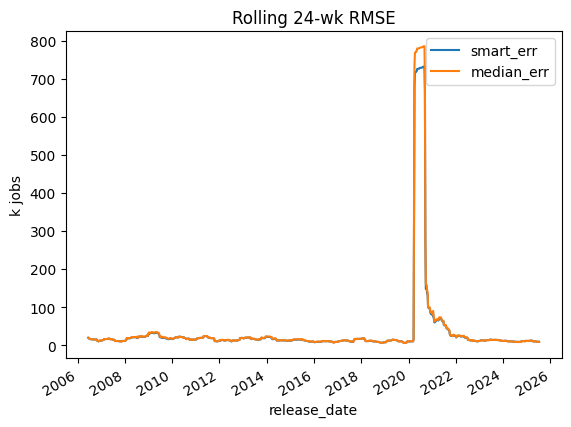

In [14]:
# pick one: "smart_err", "median_err", "smart", "median"
def rolling_rmse(panel, window=24):          # ~24 weeks = 6 months
    err_s = panel["forecast"] - panel["actual"]  # economist-level
    # collapse to release-level "smart" vs "median" first
    rel = panel.groupby("release_date").agg(
        smart   =("forecast", "mean"),   # or your weighted result
        median  =("forecast", "median"),
        actual  =("actual",   "first"))
    rel["smart_err"]  = rel["smart"]  - rel["actual"]
    rel["median_err"] = rel["median"] - rel["actual"]
    r = rel[["smart_err", "median_err"]].rolling(window).apply(
        lambda x: np.sqrt((x**2).mean()), raw=True)
    r.plot(title=f"Rolling {window}-wk RMSE", ylabel="k jobs"); plt.show()

rolling_rmse(df_full)

## EWMA 

In [ ]:
# %% [markdown]
# ░░ EWMA-weighted smart consensus • Initial Jobless Claims ░░
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from itertools import product
from scipy import stats

# ------------------------------------------------------------------
# 0 ▸ parameter grid
# ------------------------------------------------------------------
windows = [3, 6, 12, 24]          # look-back spans in *weeks*
decays  = np.arange(0.75, 1.00, 0.05)   # λ for EWMA (0.75 … 0.95)
ridge   = 1e-6

# ------------------------------------------------------------------
# 1 ▸ unique release dates (COVID-filtered panel)
# ------------------------------------------------------------------
dates = np.sort(df["release_date"].unique())

eval_rows, live_rows = [], []

# ------------------------------------------------------------------
# 2 ▸ grid search over (window, λ)
# ------------------------------------------------------------------
for window, lam in tqdm(product(windows, decays),
                        total=len(windows)*len(decays),
                        desc="EWMA tuning – IJC"):

    per_release = []                       # store all release-level records

    # walk forward after warm-up of `window` weeks
    for idx in range(window, len(dates)):
        t = dates[idx]

        # historical slice
        hist = df[df["release_date"].isin(dates[idx-window:idx])]

        # economists with *complete* forecasts in the window
        econs = (hist.groupby("economist")["forecast"]
                      .apply(lambda s: s.notna().all()))
        econs = econs[econs].index
        if econs.empty:
            continue

        # EWMA weights oldest→newest
        ew = lam ** np.arange(window-1, -1, -1)
        ew /= ew.sum()

        # EWMA-MSE score for each economist
        scores = {}
        for econ in econs:
            errs = (hist.loc[hist["economist"] == econ]
                          .sort_values("release_date")["error"]
                          .values)
            if len(errs) != window:        # guard against missing
                continue
            scores[econ] = np.sum(ew * errs**2)

        if not scores:
            continue

        w = pd.Series({e: 1/(s+ridge) for e, s in scores.items()})
        w /= w.sum()

        # current forecasts
        cur = df[(df["release_date"] == t) & (df["economist"].isin(w.index))]
        f_t = cur.set_index("economist")["forecast"].dropna()
        w   = w.reindex(f_t.index).dropna()
        if w.empty:
            continue
        w /= w.sum()

        smart   = np.dot(w, f_t.loc[w.index])
        median  = df.loc[df["release_date"] == t, "forecast"].dropna().median()
        actual  = df.loc[df["release_date"] == t, "actual"].iloc[0]
        preddir = int(smart > median)

        per_release.append((t, smart, median, actual, preddir))

    # skip if no releases scored for this (window, λ)
    if not per_release:
        continue

    oos = pd.DataFrame(per_release,
                       columns=["date", "smart", "median",
                                "actual", "pred_dir"])

    # ---- capture unreleased week (if any) ----
    unreleased = oos[oos["actual"].isna()]
    if not unreleased.empty:
        last = unreleased.iloc[-1]
        live_rows.append({"window": window, "decay": lam,
                          "date": last["date"],
                          "smart": last["smart"],
                          "median": last["median"],
                          "pred_dir": last["pred_dir"]})

    # ---- evaluate realised weeks ----
    eval_df = oos.dropna(subset=["actual"]).copy()
    if eval_df.empty:
        continue

    eval_df["smart_err"]  = eval_df["smart"]  - eval_df["actual"]
    eval_df["median_err"] = eval_df["median"] - eval_df["actual"]
    eval_df["actual_dir"] = (eval_df["actual"] > eval_df["median"]).astype(int)

    obs      = len(eval_df)
    rmse_s   = np.sqrt((eval_df["smart_err"]**2).mean())
    rmse_m   = np.sqrt((eval_df["median_err"]**2).mean())

    d        = eval_df["smart_err"]**2 - eval_df["median_err"]**2
    dm_stat  = d.mean() / d.std(ddof=1) * np.sqrt(obs)
    dm_p     = 2 * (1 - stats.norm.cdf(abs(dm_stat)))

    hits     = (eval_df["actual_dir"] == eval_df["pred_dir"]).astype(int)
    hit_rt   = hits.mean()
    binom_p  = stats.binomtest(hits.sum(), obs, 0.5).pvalue
    p1, p2   = eval_df["pred_dir"].mean(), eval_df["actual_dir"].mean()
    c_joint  = (eval_df["pred_dir"] & eval_df["actual_dir"]).mean()
    pt_stat  = (c_joint - p1*p2) / np.sqrt(p1*p2*(1-p1)*(1-p2)/obs)
    pt_p     = 2 * (1 - stats.norm.cdf(abs(pt_stat)))

    eval_rows.append({"window": window, "decay": lam, "obs": obs,
                      "RMSE_smart": rmse_s, "RMSE_median": rmse_m,
                      "HitRate": hit_rt, "Binom_p": binom_p,
                      "PT_p": pt_p, "DM_p": dm_p})

# ------------------------------------------------------------------
# 3 ▸ summarise grid & pick robust winner
# ------------------------------------------------------------------
results_df = (pd.DataFrame(eval_rows)
              .sort_values(["window", "decay"])
              .reset_index(drop=True))

pd.set_option("display.float_format", "{:.3f}".format)
print("\n--- EWMA evaluation • IJC COVID-filtered panel ---")
print(results_df.to_string(index=False))

# robust winner: significant on DM, Binom, PT; then lowest RMSE
candidates = results_df[(results_df["DM_p"]   < 0.10) &
                        (results_df["Binom_p"]< 0.10) &
                        (results_df["PT_p"]   < 0.10)]
winner_row = (candidates if not candidates.empty else results_df).loc[
                 lambda d: d["RMSE_smart"].idxmin()]

w_win, d_win = int(winner_row["window"]), float(winner_row["decay"])

# ------------------------------------------------------------------
# 4 ▸ print live forecast (if present)
# ------------------------------------------------------------------
live_df = pd.DataFrame(live_rows)

if live_df.empty:
    print("\nNo unreleased week – all actuals available.")
else:
    live_sel = live_df[(live_df["window"] == w_win) &
                       (live_df["decay"]  == d_win)]

    if live_sel.empty:
        print("\nRobust-winner spec has no live forecast row "
              "(window/λ combo didn’t survive the guards).")
    else:
        row = live_sel.iloc[-1]
        dir_txt = "Beat" if row["pred_dir"] else "Miss"
        print("\n--- LIVE EWMA IJC FORECAST (robust winner) ---")
        print(f"Week ending : {row['date'].date()}")
        print(f"Smart       : {row['smart']:.0f} k claims")
        print(f"Median      : {row['median']:.0f} k claims")
        print(f"Direction   : {dir_txt}  (window={w_win} wk, λ={d_win:.2f})")


EWMA tuning – IJC:   0%|          | 0/20 [00:00<?, ?it/s]


--- EWMA evaluation • IJC COVID-filtered panel ---
 window  decay  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_p  DM_p
      3  0.750  859      15.158       15.581    0.545    0.009 0.005 0.000
      3  0.800  859      15.160       15.581    0.541    0.017 0.009 0.000
      3  0.850  859      15.163       15.581    0.544    0.012 0.006 0.000
      3  0.900  859      15.165       15.581    0.542    0.014 0.008 0.000
      3  0.950  859      15.168       15.581    0.547    0.006 0.003 0.000
      6  0.750  856      15.133       15.578    0.551    0.003 0.001 0.000
      6  0.800  856      15.133       15.578    0.553    0.002 0.001 0.000
      6  0.850  856      15.133       15.578    0.555    0.001 0.001 0.000
      6  0.900  856      15.133       15.578    0.553    0.002 0.001 0.000
      6  0.950  856      15.133       15.578    0.553    0.002 0.001 0.000
     12  0.750  850      15.237       15.595    0.558    0.001 0.000 0.002
     12  0.800  850      15.237       15.595    